## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd "/content/drive/MyDrive/CS4701/"

Mounted at /content/drive
/content/drive/MyDrive/CS4701


In [3]:
ROOT_DIR = os.path.abspath(".")

BASE_DIR = os.path.join(ROOT_DIR, "tensorflow/historical_images")
WORKING_DIR = os.path.join(ROOT_DIR, "tensorflow/")

## Extract Image Features

In [4]:
# vgg16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    # num -= 1

  0%|          | 0/1325 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [2]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
print(features)

NameError: ignored

## Load the Captions Data

In [24]:
# with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
with open(os.path.join(BASE_DIR, 'captions_with_decade.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [1]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption, decade = tokens[0], tokens[1], tokens[2:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]

    decade = " ".join(decade)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
    mapping[image_id].append(decade)

NameError: ignored

c

In [3]:
len(mapping)
print(mapping)

{}


## Preprocess Text Data

In [28]:
def clean(mapping):
    for key, values in mapping.items():
        caption, decade = values
        # preprocessing steps
        # convert to lowercase
        caption = caption.lower()
        # delete digits, special chars, etc.,
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

        values[0] = caption

In [7]:
# before preprocess of text
# print(mapping)
mapping['1930s_1']

KeyError: ignored

In [30]:
# preprocess the text
clean(mapping)

In [31]:
# after preprocess of text
mapping['1930s_1']

['startseq man and woman are standing on boat during the 1930s endseq',
 '1930s']

In [8]:
all_captions = []
for key in mapping:
    all_captions.append(mapping[key][0])
# print(all_captions)

In [33]:
len(all_captions)

1325

In [9]:
# all_captions[:10]

In [10]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

NameError: ignored

In [38]:
vocab_size

571

In [39]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

17

## Train Test Split

In [5]:
import random
image_ids = list(mapping.keys())
# random.shuffle(image_ids)
# split = int(len(image_ids) * 0.90)
train = []
test = []
img_per_decade = 265
split = int(img_per_decade * 0.90)

decades = ["1930s", "1940s", "1950s", "1960s", "1970s"]
for i in range(len(decades)):
  for idx in range(i * img_per_decade, i * img_per_decade + split):
    train.append(image_ids[idx])
  for idx in range(i * img_per_decade + split, (i + 1) * img_per_decade):
    test.append(image_ids[idx])

# print(train)
# print(test)
# print(len(train))
# print(len(test))

IndexError: ignored

In [66]:
date_mapping = {"1930s" : 0, "1940s" : 1, "1950s" : 2, "1960s" : 3, "1970s" : 4}
rev_date_mapping = {0 : "1930s", 1 : "1940s", 2 : "1950s", 3 : "1960s", 4 : "1970s"}

In [67]:
def data_generator_cap(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = [mapping[key][0]]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


def data_generator_date(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, y2 = list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1

            date = date_mapping[mapping[key][1]]
            X1.append(features[key][0])
            y2.append(date)

            if n == batch_size:
                X1, y2 = np.array(X1), np.array(y2)
                yield X1, y2
                X1, y2 = list(), list()
                n = 0

## Model Creation

input: image feature, current sequence

output: next token, date

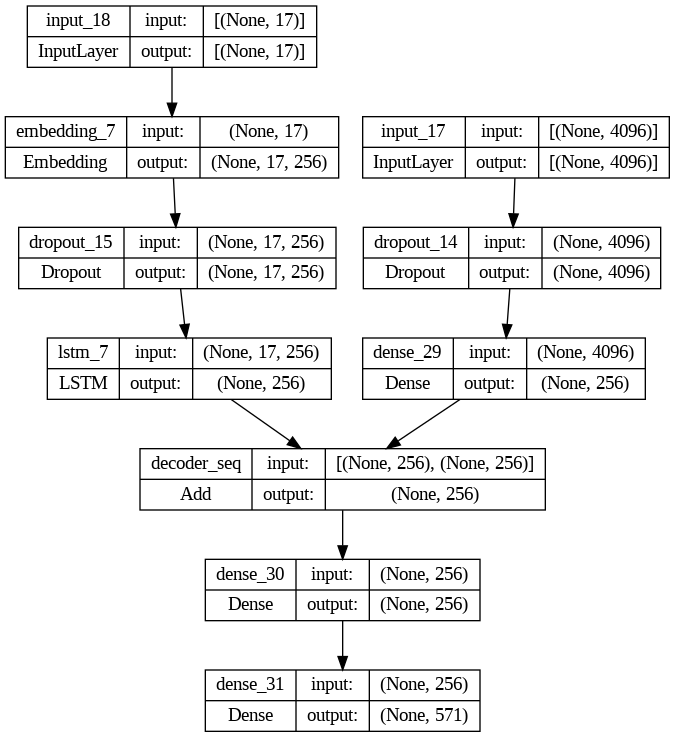

In [84]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,))
# se1 =  wi(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3], name = "decoder")
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # plot the model
# plot_model(model, show_shapes=True)


# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3], name = "decoder_seq")
decoder2 = Dense(256, activation='relu')(decoder1)
output_seq = Dense(vocab_size, activation='softmax')(decoder2)

cap_model = Model(inputs=[inputs1, inputs2], outputs=output_seq)
cap_model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(cap_model, show_shapes=True)

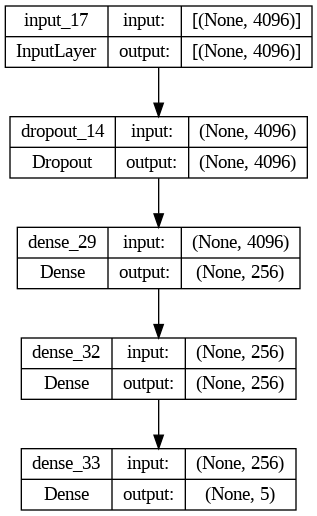

In [85]:
# decoder3 = add([fe2], name = "decoder_date")
decoder4 = Dense(256, activation='relu')(fe2)
output_date = Dense(5, activation='softmax')(decoder4)

date_model = Model(inputs=inputs1, outputs=output_date)
date_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
plot_model(date_model, show_shapes=True)

In [86]:
# train the model
# epochs = 20
epochs_cap, epochs_date = 10, 2
batch_size = 16
steps = len(train) // batch_size
# print(features)
# print(mapping)
print(len(train), len(mapping), len(features))

for i in range(epochs_cap):
    # create data generator
    generator = data_generator_cap(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    cap_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

for i in range(epochs_date):
    # create data generator
    generator = data_generator_date(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    date_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1190 1325 1325
74/74 [==============================] - 0s 3ms/step - loss: 2.0695


In [77]:
# save the model
# cap_model.save(WORKING_DIR+'/best_model_cap_10_epochs.h5')
date_model.save(WORKING_DIR+'/best_model_date_1_epochs.h5')
# cap_model.save(WORKING_DIR+'/cap.keras')
date_model.save(WORKING_DIR+'/date.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for the Image

In [78]:
# Load model
cap_model = load_model(WORKING_DIR + '/cap.keras')
date_model = load_model(WORKING_DIR + '/date.keras')

In [44]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [45]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # get index with high probability
        caption = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(caption, tokenizer)

        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    # print(in_text)

    return in_text

# generate caption for an image
def predict_date(model, image):
    yhat = model.predict([image], verbose=0)
    date = np.argmax(yhat)
    date = rev_date_mapping[date]
    return date

In [87]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted, actual_date, predicted_date = list(), list(), list(), list()

for key in tqdm(test):
    # get actual caption
    captions, date_actual = mapping[key]
    # predict the caption for image
    cap_pred = predict_caption(cap_model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in [captions]]
    cap_pred = cap_pred.split()
    # append to the list
    actual.append(actual_captions)
    # print(actual_captions)
    predicted.append(cap_pred)

    date_pred = predict_date(date_model, features[key])
    actual_date.append(date_actual)
    predicted_date.append(date_pred)

# calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.34, 0)))
# print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

confusion_matrix = [[0] * 5 for i in range(5)]

for i in range(len(actual_date)):
  true, pred = actual_date[i], predicted_date[i]
  true_idx, pred_idx = date_mapping[true], date_mapping[pred]
  confusion_matrix[pred_idx][true_idx] += 1

print(confusion_matrix)

  0%|          | 0/135 [00:00<?, ?it/s]

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [27, 27, 27, 27, 27], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [80]:
np.transpose(np.array(confusion_matrix))

array([[ 0,  0,  0, 27,  0],
       [ 0,  0,  0, 27,  0],
       [ 0,  0,  0, 27,  0],
       [ 0,  0,  0, 27,  0],
       [ 0,  0,  0, 27,  0]])

## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    caption, date = mapping[image_id]
    print('---------------------Actual---------------------')
    # for caption in captions:
    print("Caption: ", caption)
    print("Date: ", date)
    # predict the caption
    cap_pred = predict_caption(cap_model, features[image_id], tokenizer, max_length)
    date_pred = predict_date(date_model, features[image_id])
    print('--------------------Predicted--------------------')
    print("Caption: ", cap_pred)
    print("Date: ", date_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1930s_264.jpg")

In [ ]:
generate_caption("1940s_264.jpg")

In [ ]:
generate_caption("1950s_264.jpg")

In [ ]:
generate_caption("1960s_264.jpg")

In [ ]:
generate_caption("1970s_250.jpg")

## Test with Real Image

In [51]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [62]:
image_path = BASE_DIR + "/test/test_1.jpg"

# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
print(predict_caption(cap_model, feature, tokenizer, max_length))
print(predict_date(date_model, feature))

startseq woman sitting in living living living living room during the 1960s endseq
1940s


In [63]:
image_path = BASE_DIR + "/test/test_2.jpg"

# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
print(predict_caption(cap_model, feature, tokenizer, max_length))
print(predict_date(date_model, feature))

startseq woman sitting on top of people on the phone during the 1960s endseq
1960s


In [64]:
image_path = BASE_DIR + "/test/test_3.jpg"

# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
print(predict_caption(cap_model, feature, tokenizer, max_length))
print(predict_date(date_model, feature))

startseq man and woman sitting on top of wooden during the 1960s endseq
1940s
